In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from utils.make_data import generate_autoregressive_forecast_dataset
from models.conformal import nonconformity, cover, ConformalForecaster

## Generate datasets

In [9]:
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=10)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=10)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=5000, seq_len=100, horizon=10)

## Conformal forecaster

In [5]:
model = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [6]:
model.fit(train_dataset, calibration_dataset, epochs=100, lr=0.01, batch_size=100)

Epoch: 0	Train loss: 114.99885864257813
Epoch: 50	Train loss: 15.0904296875


In [48]:
model.eval()
c = []
predictions = []
for sequences, target in test_dataset:
    sequences = sequences.unsqueeze(dim=0)
    out = model(sequences).squeeze()
    pred = torch.vstack([out - model.critical_calibration_scores,
                         out + model.critical_calibration_scores]).T
    predictions.append(pred)
    c.append(cover(pred, target))
print('% of series within predicted intervals: {}'.format(np.mean(c)))

% of series within predicted intervals: 0.7308


In [65]:
false_idx = np.nonzero(np.invert(c))[0]

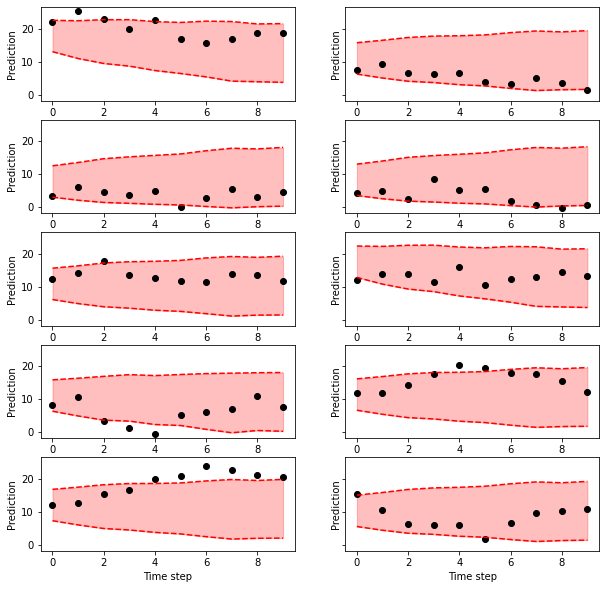

In [86]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

for ax in axs.flat:
    i = np.random.choice(false_idx)
    ax.fill_between(range(test_dataset[i][1].size(0)),
                     predictions[i][:, 0].detach().numpy(), 
                     predictions[i][:, 1].detach().numpy(), 
                     color="r", alpha=0.25)
    ax.plot(predictions[i][:, 0].detach().numpy(), linestyle="--", color="r")
    ax.plot(predictions[i][:, 1].detach().numpy(), linestyle="--", color="r")
    # plt.plot(Y_predicted[0][0], linestyle="--", linewidth=3, color="r")

    ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].detach().numpy(), color="black")
    
    ax.set(xlabel='Time step', ylabel='Prediction')